In [19]:
from setup_notebook import setup_project_path
setup_project_path()
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [20]:
df = pd.read_csv("../data/raw/predictions_in_production.csv")
df.columns = [i.lower().replace(" ", "_") for i in df.columns]
df = df.rename({"registration_date_month": "reg_month", "date_uploaded_date": "date_uploaded"}, axis=1)
print(df.shape)
df["date_uploaded"] = pd.to_datetime(df["date_uploaded"])
df["reg_month"] = pd.to_datetime(df["reg_month"], format="%Y-%m")
df.head()

(3198, 6)


,date_uploaded,country,product_group,reg_month,predicted_frr_updated,count
0,2025-09-01,Kenya,SHS Entry-Level Upgrade,2025-07-01,0.874286,2338
1,2025-09-01,Togo,Phones,2025-07-01,0.978315,13
2,2025-09-01,Kenya,SHS Entry-Level,2025-07-01,0.854527,7508
3,2025-09-01,Tanzania,Lanterns,2025-07-01,0.793343,2281
4,2025-09-01,Nigeria,SHS without TV,2025-07-01,0.978855,1418


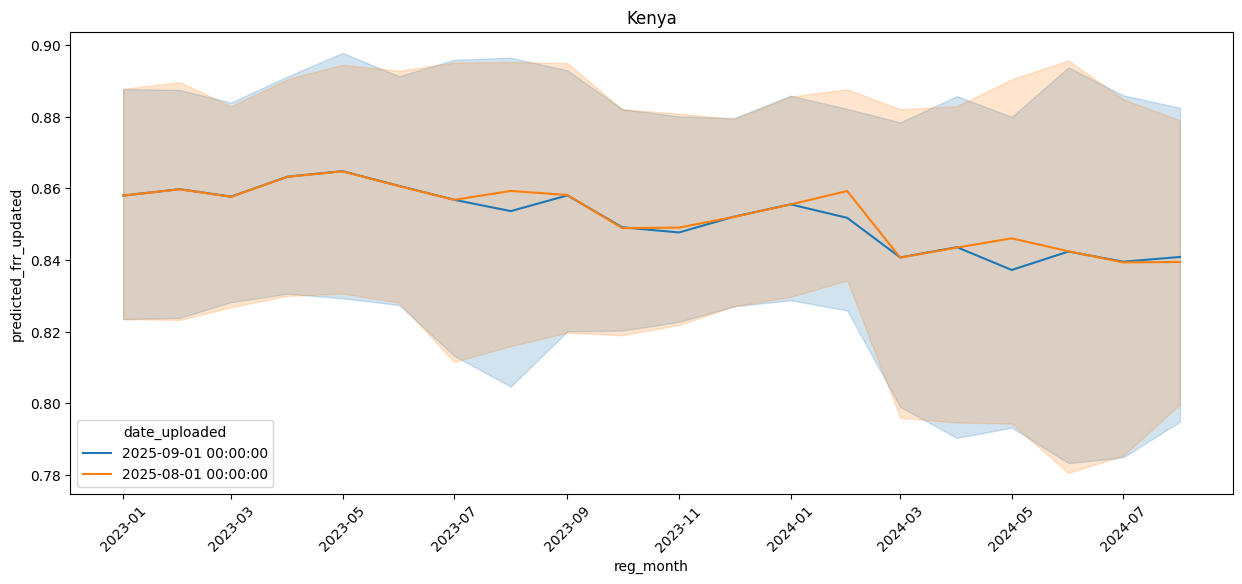

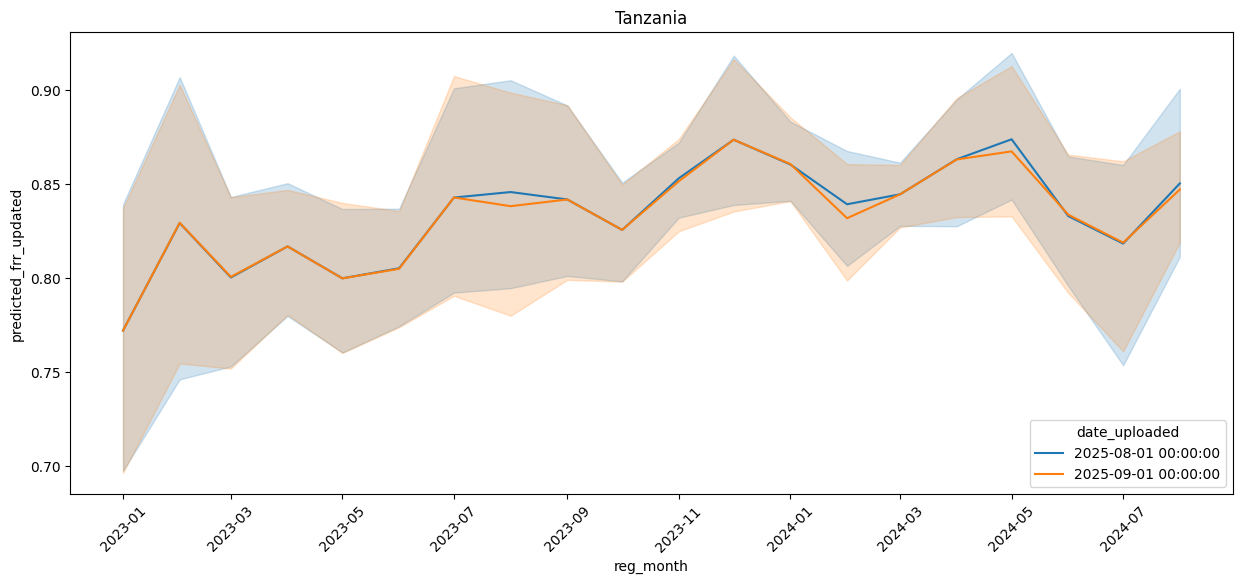

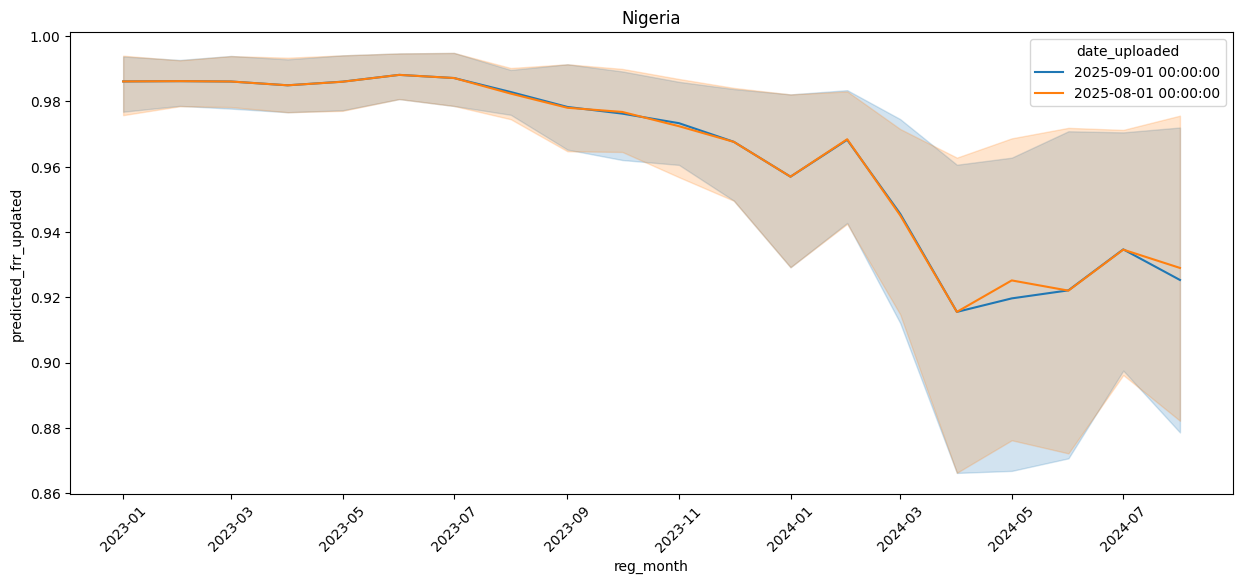

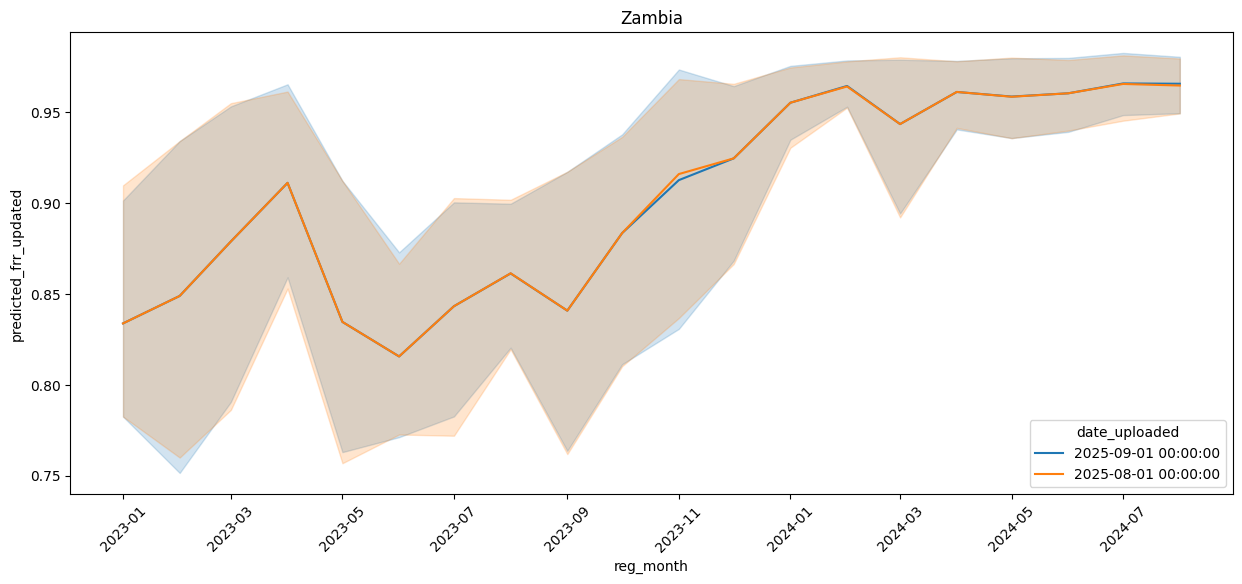

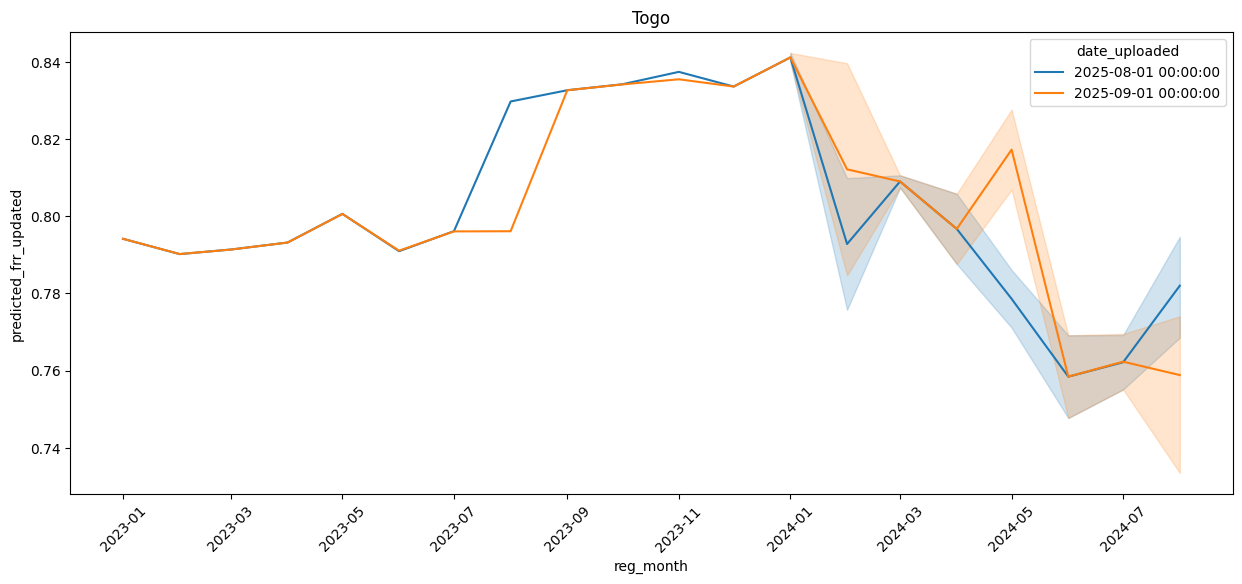

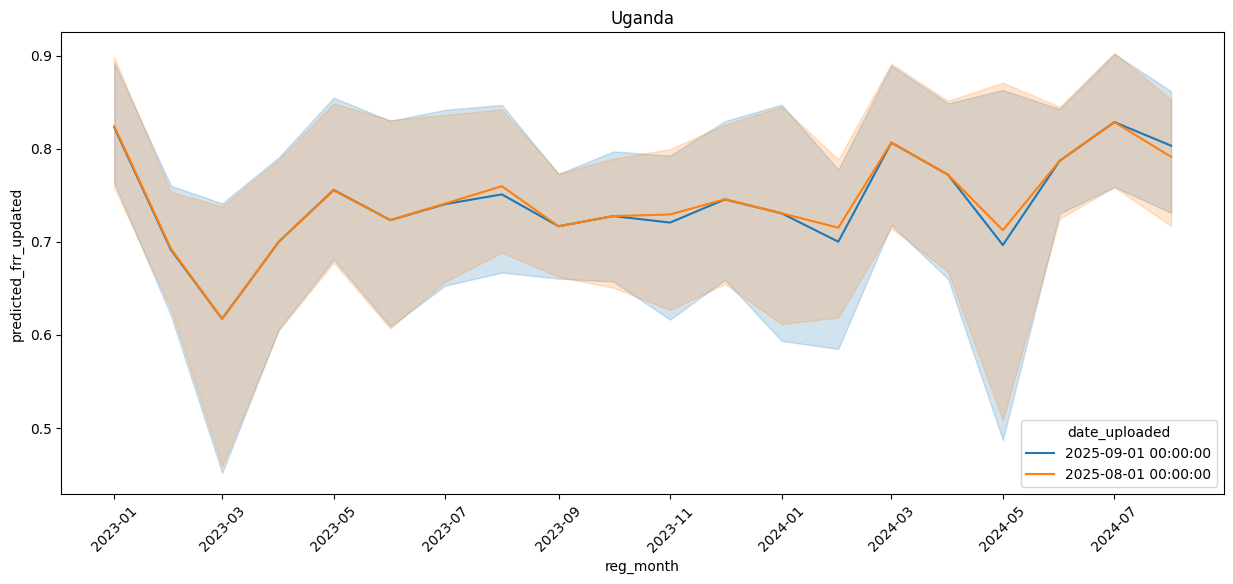

In [21]:
for country in ["Kenya", "Tanzania", "Nigeria", "Zambia", "Togo", "Uganda"]:
    plt.figure(figsize=(15, 6))
    sns.lineplot(data=df[(df.country==country) & (df.reg_month>="2023-01-01") & (df.reg_month<="2024-08-01")], x="reg_month", y="predicted_frr_updated", hue="date_uploaded")
    # sns.lineplot(data=df2, x="reg_month", y="frr_prediction_50")
    plt.xticks(rotation=45)
    plt.title(country)
    plt.show()

In [22]:
pivoted = df.pivot_table(
    index=["country", "product_group","reg_month",],
    columns="date_uploaded",
    values=["predicted_frr_updated", "count"]
).reset_index()
pivoted.columns = [
    str(c[0]) if c[1] == "" or pd.isna(c[1]) else f"{c[0]}_{c[1].date()}"
    for c in pivoted.columns.to_flat_index()
]
pivoted["reg_month"] = pd.to_datetime(pivoted["reg_month"])

pivoted["diff"] = pivoted["predicted_frr_updated_2025-09-01"] - pivoted["predicted_frr_updated_2025-08-01"]
pivoted.head()

backtestings = np.array([30, 60, 90, 180, 270, 360, 450, 540, 630, 720], dtype=int)
months = backtestings // 30

base_current = pd.to_datetime("2025-09-01")
base_prev = pd.to_datetime("2025-08-01")

backtesting_month_current = [base_current - pd.DateOffset(months=m+1) for m in months]
backtesting_month_prev = [base_prev - pd.DateOffset(months=m+2) for m in months]

data = {
    "Months": months,
    "backtesting_month_current": backtesting_month_current,
    "backtesting_month_prev": backtesting_month_prev,
    "backtesting_shift": backtestings,
}
backtestings_df = pd.DataFrame(data)

print(backtestings_df)

discrepancies = pd.merge(left=pivoted, right=backtestings_df, left_on="reg_month", right_on="backtesting_month_current", how="left")
discrepancies["backtesting_shift"] = discrepancies["backtesting_shift"].astype("Int64")
discrepancies = discrepancies[discrepancies.backtesting_shift.isin([450, 540, 630, 720])]

# discrepancies["diff"] = (discrepancies["predicted_frr_updated_2025-08"] - discrepancies["predicted_frr_updated_2025-07"]).round(4)*100


   Months backtesting_month_current backtesting_month_prev  backtesting_shift
0       1                2025-07-01             2025-05-01                 30
1       2                2025-06-01             2025-04-01                 60
2       3                2025-05-01             2025-03-01                 90
3       6                2025-02-01             2024-12-01                180
4       9                2024-11-01             2024-09-01                270
5      12                2024-08-01             2024-06-01                360
6      15                2024-05-01             2024-03-01                450
7      18                2024-02-01             2023-12-01                540
8      21                2023-11-01             2023-09-01                630
9      24                2023-08-01             2023-06-01                720


In [25]:
discrepancies_country = discrepancies.groupby(["country", "reg_month", "backtesting_shift"]).agg(diff2=("diff", "mean")).reset_index()

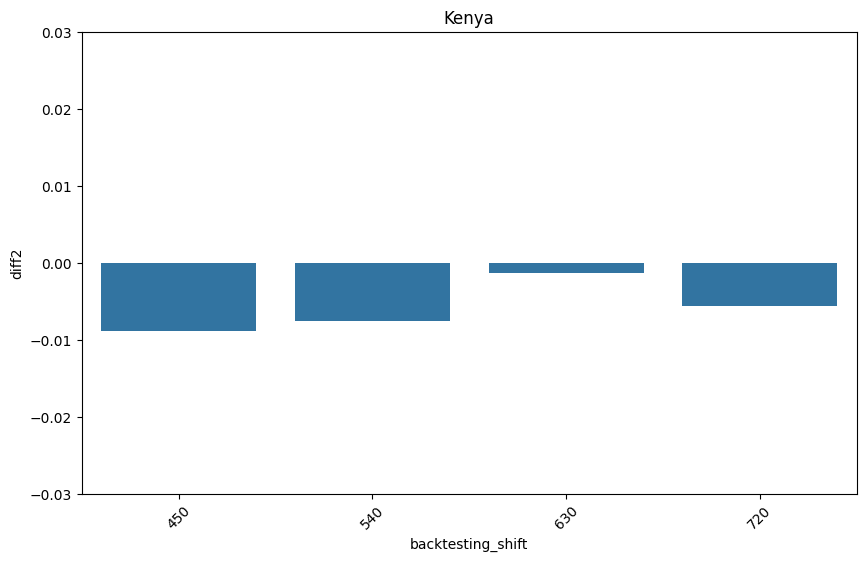

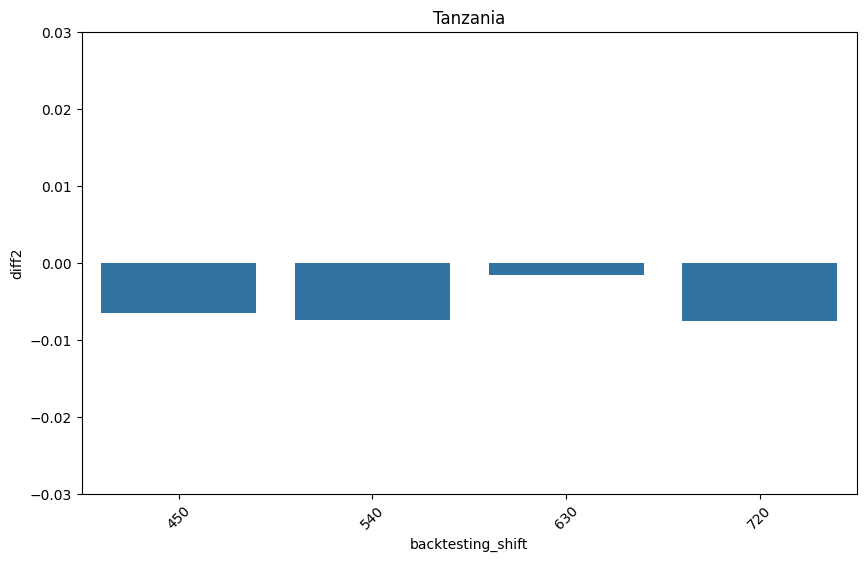

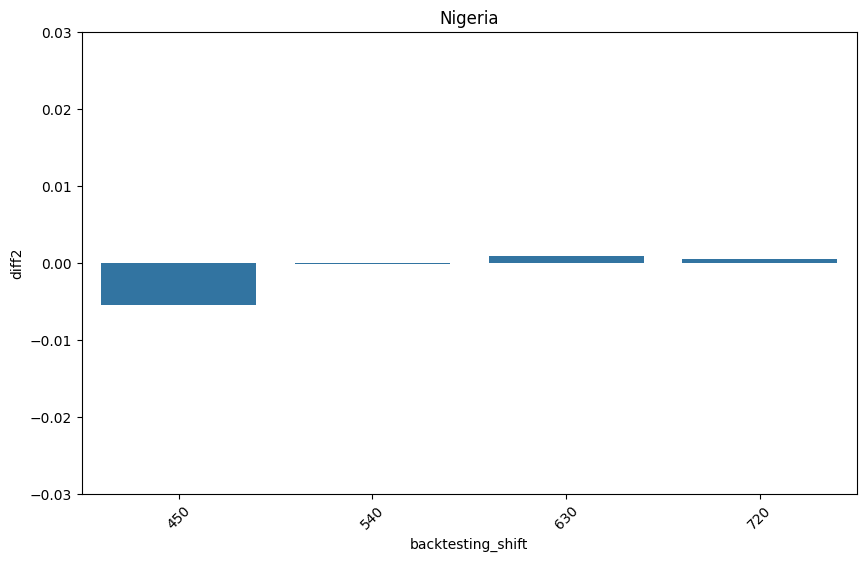

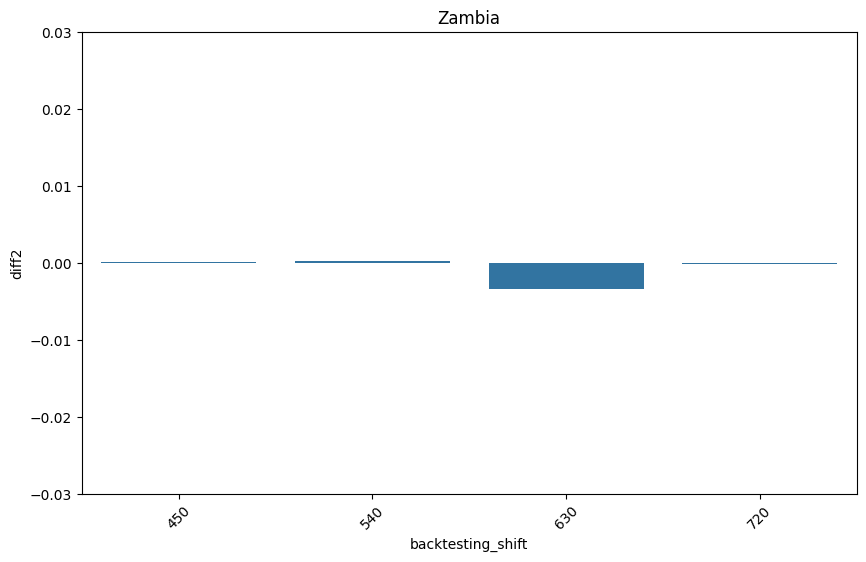

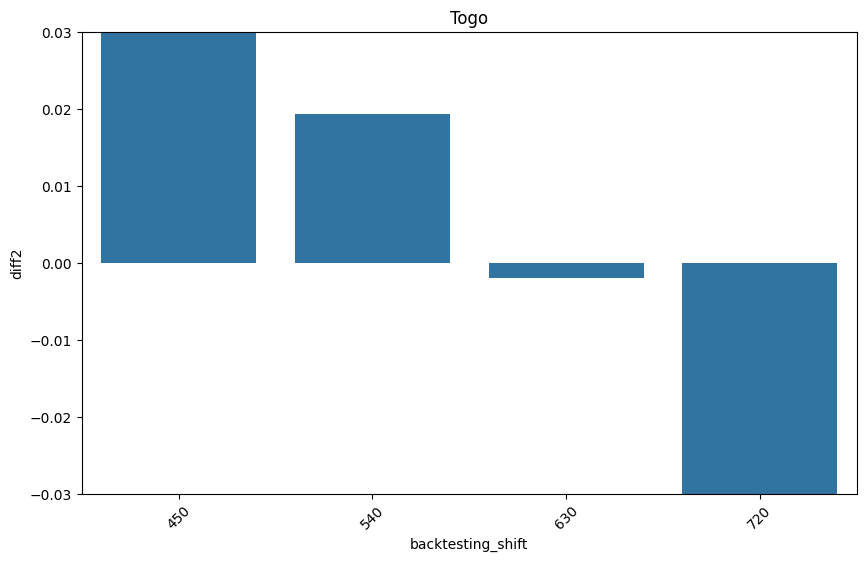

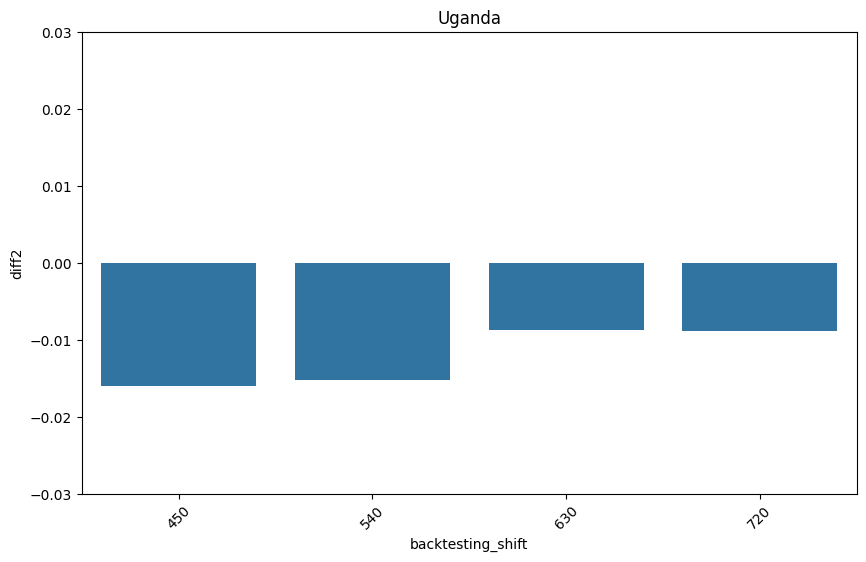

In [26]:
for country in ["Kenya", "Tanzania", "Nigeria", "Zambia", "Togo", "Uganda"]:
    plt.figure(figsize=(10, 6))
    plt.ylim((-0.03, 0.03))
    sns.barplot(data=discrepancies_country[discrepancies_country.country==country], x="backtesting_shift", y="diff2")
    # sns.lineplot(data=df2, x="reg_month", y="frr_prediction_50")
    plt.xticks(rotation=45)
    plt.title(country)
    plt.show()

In [27]:
discrepancies_country[discrepancies_country.country.isin(["Kenya", "Nigeria", "Tanzania", "Uganda", "Zambia", "Togo"])].groupby("country").agg(
    mean_diff = ("diff2", "mean"),
    min_diff = ("diff2", "min"),
    max_diff = ("diff2", "max"),
    median_diff = ("diff2", "median"),
).reset_index()

,country,mean_diff,min_diff,max_diff,median_diff
0,Kenya,-0.005822,-0.008825,-0.001348,-0.006557
1,Nigeria,-0.001065,-0.005507,0.000926,0.000161
2,Tanzania,-0.005733,-0.007507,-0.001579,-0.006924
3,Togo,0.005613,-0.033614,0.038642,0.008712
4,Uganda,-0.012130,-0.015909,-0.008698,-0.011957
5,Zambia,-0.000756,-0.003343,0.000288,0.000015
